In [490]:
"""
@author: maximefontana
"""
# System
import sys

# Graph Data
import snap
import networkx as nx

# Scientific Computing 
import numpy as np
import scipy
import pandas as pd
import csv

# Math
import random as ran
from time import time

# Custom imports
%run Algorithms.ipynb
%run ClusteringEvaluation.ipynb
%run PlotFunctions.ipynb
%run GroundTruthGen.ipynb
%run SBM.ipynb

# Specific models
from sklearn.cluster import SpectralClustering, KMeans
from sklearn import metrics
from sklearn import preprocessing

# Plotting
#import tensorflow as tf
from matplotlib import pyplot as plt

In [491]:
def perturbation_remove_nodes(G, p, random=False, greatest_degrees=False):
    size = len(G)
    proportion = np.ceil((p*size) / 100)
    
    if random:
        random_partition = ran.sample(list(G.nodes()), int(proportion))
        G.remove_nodes_from(random_partition)
        
    if greatest_degrees:
        sorted_degrees = sorted(list(G.degree()), key=lambda x: x[1], reverse=True)
        sub_portion = sorted_degrees[:int(proportion)]
        sub_portion_2 = [item[0] for item in sub_portion]
        G.remove_nodes_from(sub_portion_2)
        
    return G

In [492]:
# Import dataset
df = pd.read_csv('datasets/Friendship-network_data_2013.csv')

In [493]:
# Take a glance at what the data looks like
df.shape

(667, 1)

In [494]:
# Transform the only column into a list of tuples
connections = tuple(list(df['1 55']))

134


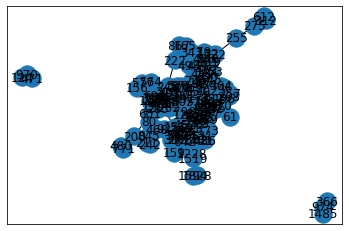

In [495]:
# Construct the graphs by adding edges representing friendships
G = nx.Graph()
for i in range(len(connections)):
    vertice_string = int(connections[i].split(" ")[0]) # to get the first element of the string
    vertice_connection = int(connections[i].split(" ")[1]) # to get the second element of the string
    G.add_edge(vertice_string, vertice_connection)
    
    
G.add_edge(1, 55) # Manually add to fix the header issue (as it represents actual value)
print(len(G.nodes()))
nx.draw_networkx(G)
plt.show()

In [496]:
### NOW TO DEAL WITH HOW TO ADD GENDERS TO STUDENTS' IDs
students_list = []
with open('datasets/metadata_2013.txt', newline = '') as students:                                                                                          
        student_reader = csv.reader(students, delimiter='\t')
        for student in student_reader:
            students_list.append(student)

In [497]:
pd.DataFrame(students_list).to_csv("datasets/students2013.csv")
data = pd.read_csv('datasets/students2013.csv')

In [498]:
elems_to_remove = np.asarray(data[data['2'] == 'Unknown']['0'])
print(elems_to_remove) 

[ 34  41 243 420  58 209 979]


In [499]:
for i in range(len(elems_to_remove)):
    if elems_to_remove[i] in G.nodes():
        G.remove_node(elems_to_remove[i])
        
print(len(G))
perturbation_remove_nodes(G, 50, random = True)
print(len(G))

133
66


In [500]:
# Check if nodes have been removed
print(len(G.nodes())) # node 34 has been removed

66


In [501]:
# Clean the rows with 'Unknown' gender
data = data.drop(data[data['2'] == 'Unknown'].index)
data.shape # Verify new shape (7 rows removed)

(322, 4)

In [502]:
data

,Unnamed: 0,0,1,2
0,0,650,2BIO1,F
1,1,498,2BIO1,F
2,2,627,2BIO1,F
3,3,857,2BIO1,F
4,4,487,2BIO1,F
...,...,...,...,...
317,317,642,MP,M
318,318,245,MP,F
319,319,525,MP,F
327,327,205,2BIO3,M


In [503]:
# Powerset of female students
x = np.asarray(data['0'].where(data['2'] == 'F'))
x = x[~np.isnan(x)]
print(np.sort(x))

[  39.   45.   46.   47.   55.   61.   62.   63.   70.   72.   79.   80.
   85.   87.  101.  106.  111.  119.  120.  122.  124.  125.  132.  134.
  145.  156.  160.  165.  170.  172.  173.  176.  177.  179.  199.  202.
  210.  211.  213.  214.  222.  226.  232.  239.  240.  242.  245.  252.
  255.  257.  258.  265.  268.  272.  275.  277.  280.  285.  295.  312.
  333.  339.  343.  346.  364.  374.  388.  391.  400.  425.  434.  440.
  441.  443.  447.  450.  454.  464.  465.  468.  471.  478.  486.  487.
  489.  491.  498.  502.  504.  520.  525.  531.  545.  548.  576.  577.
  587.  601.  612.  626.  627.  637.  647.  649.  650.  674.  681.  694.
  706.  720.  753.  763.  765.  777.  778.  779.  784.  797.  809.  836.
  843.  845.  854.  857.  867.  874.  883.  884.  886.  894.  908.  920.
  921.  927.  941.  945.  954.  958.  970.  984. 1201. 1332. 1342. 1412.
 1594. 1894.]


In [504]:
# Powerset of male students
y = np.asarray(data['0'].where(data['2'] == 'M'))
y = y[~np.isnan(y)].astype(int)
print(np.sort(y))

[   1    2    3    4    9   14   15   20   21   27   28   32   38   48
   54   65   71   89   90   92  103  115  116  117  131  147  149  151
  159  171  181  184  185  190  194  196  200  201  205  219  220  227
  236  241  246  248  253  254  256  267  269  274  276  279  290  306
  311  322  325  327  335  353  356  366  372  376  382  387  390  407
  413  424  428  429  435  438  445  446  448  452  453  466  475  477
  480  484  488  492  494  496  497  510  513  527  533  544  564  582
  603  605  615  621  622  624  634  638  640  642  653  655  658  677
  687  691  702  725  743  744  751  769  771  786  790  791  798  826
  841  859  866  869  871  882  893  909  917  923  938  939  959  960
  974  977  991  998 1067 1204 1212 1214 1216 1218 1228 1232 1237 1238
 1260 1295 1320 1324 1336 1339 1345 1359 1366 1383 1401 1423 1485 1512
 1518 1519 1543 1784 1805 1819 1828 1870]


In [505]:
# So there are 322 Students (176 male students & 146 female students) in the big metadata file
# We have 133 students in our dataset

x_y_join = np.concatenate((x, y)).astype(int)
difference = np.setdiff1d(x_y_join, np.asarray(G.nodes()))
print(difference)

[   1    2    3    4    9   14   15   20   21   27   28   38   39   45
   47   54   61   62   65   70   71   72   79   80   85   87   89   90
   92  101  103  106  111  115  116  119  125  131  132  145  149  159
  160  171  172  173  176  177  179  181  184  185  194  196  199  205
  210  211  214  219  220  222  226  227  232  236  239  240  241  242
  246  253  254  255  256  258  267  269  272  274  276  277  279  280
  285  290  295  306  311  312  322  325  333  335  339  346  353  356
  366  372  374  376  382  387  390  391  400  407  413  424  428  429
  434  435  438  443  445  446  448  450  452  453  454  464  465  466
  471  475  477  478  484  487  489  496  497  498  502  504  510  513
  520  525  527  533  544  545  548  564  576  577  582  601  605  615
  621  622  624  626  627  637  638  640  642  647  649  650  653  655
  658  677  681  687  702  706  720  725  743  744  751  753  763  769
  777  778  784  786  790  791  798  809  826  836  841  843  854  857
  859 

In [506]:
# Now let's remove elements that we do not have in our graph from our powerset
for i in range(len(difference)):
    if difference[i] in x:
        x = np.delete(x, np.where(x == difference[i]))
    elif difference[i] in y:
        y = np.delete(y, np.where(y == difference[i]))
        
print(len(x))
print(len(y))
print("Equal size between nodes and gender list ?", len(x)+len(y) == len(G.nodes()))

43
23
Equal size between nodes and gender list ? True


In [507]:
# Now that we have everything, our dataset made of 133 students as well as their genders
female_students = x 
male_students = y

In [508]:
print(np.sort(female_students))

[  46.   55.   63.  120.  122.  124.  134.  156.  165.  170.  202.  213.
  245.  252.  257.  265.  268.  275.  343.  364.  388.  425.  440.  441.
  447.  468.  486.  491.  531.  587.  612.  674.  694.  765.  779.  797.
  845.  867.  883.  884.  894.  920. 1332.]


In [509]:
print(np.sort(male_students))

[  32   48  117  147  151  190  200  201  248  327  480  488  492  494
  603  634  691  771  866  869  959 1401 1485]


In [510]:
print(G.nodes())

[494, 779, 894, 147, 674, 884, 63, 202, 327, 441, 492, 32, 440, 797, 920, 151, 866, 48, 765, 46, 117, 257, 268, 55, 170, 252, 883, 425, 447, 120, 468, 190, 213, 603, 845, 122, 343, 364, 265, 587, 488, 124, 248, 491, 134, 388, 201, 634, 691, 694, 869, 156, 165, 1332, 200, 480, 245, 867, 959, 275, 612, 486, 531, 771, 1401, 1485]


In [511]:
labels = un_spectral(G, 2)
print(labels)

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0]


In [512]:
fair_labels = un_spectral_fair(G, 2, labels)
print(fair_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [513]:
gender_partition = np.zeros(len(G.nodes()))
print(gender_partition)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [514]:
# Fill in gender partition 

for i in range(len(G.nodes())):
    if list(G)[i] in female_students:
        gender_partition[i] = 0
    elif list(G)[i] in male_students:
        gender_partition[i] = 1
        
print(gender_partition)
print(len(gender_partition))
occurrences1 = np.count_nonzero(gender_partition == 1)
occurrences0 = np.count_nonzero(gender_partition == 0)

print(occurrences1, ' and', occurrences0)

[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
66
23  and 43


In [515]:
print(len(list(G.nodes())))

66


In [516]:
print(balance(gender_partition.astype(int), labels))

-2.0


In [517]:
print(balance(gender_partition.astype(int), fair_labels))

-18.5


In [518]:
fair_results = []
unfair_results = []
balance_fairness = []

unfair_ratio_cuts = []
fair_ratio_cuts = []
for k in range(2,16):
    labels = un_spectral(G, k)
    fair_labels = un_spectral_fair(G, k, labels)
    
    fair_results.append(balance(gender_partition.astype(int), fair_labels))
    unfair_results.append(balance(gender_partition.astype(int), labels))
    balance_fairness.append(balance(gender_partition.astype(int), gender_partition.astype(int)))
    
    #unfair_ratio_cuts.append(labels_rc)
    #fair_ratio_cuts.append(fair_labels_rc)

In [519]:
print(fair_results)

[-18.5, -33.666666666666664, -27.75, -28.0, -26.333333333333332, -29.0, -22.5, -22.666666666666668, -34.9, -40.45454545454545, -36.083333333333336, -40.61538461538461, -40.642857142857146, -43.4]


In [520]:
print(unfair_results)

[-2.0, -4.333333333333333, -22.75, -24.2, -24.833333333333332, -26.857142857142858, -29.125, -33.666666666666664, -32.5, -31.181818181818183, -32.5, -33.38461538461539, -31.785714285714285, -35.0]


Spectral Clustering results : -26.00840171733029
Fair Spectral Clustering results : -31.750913372341937


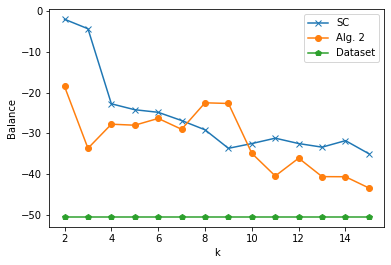

In [521]:
axis_x = np.arange(2, 16, 1)

plt.plot(axis_x, unfair_results, label = 'SC', marker='x')
plt.plot(axis_x, fair_results, label = 'Alg. 2', marker='o')
plt.plot(axis_x, balance_fairness, label = 'Dataset', marker='p')
print('Spectral Clustering results :', np.mean(unfair_results))
print('Fair Spectral Clustering results :', np.mean(fair_results))
plt.xlabel('k')
# Set the y axis label of the current axis.
plt.ylabel('Balance')
# Set a title of the current axes.
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [522]:
fair_results = []
unfair_results = []

#unfair_ratio_cuts = []
#fair_ratio_cuts = []

for k in range(2,16):
    labels = un_spectral(G, k, normalised=True)
    fair_labels = norm_spectral_fair(G, k, labels)
    
    fair_results.append(balance(gender_partition.astype(int), fair_labels))
    unfair_results.append(balance(gender_partition.astype(int), labels))
    
    #unfair_ratio_cuts.append(labels_rc)
    #fair_ratio_cuts.append(fair_labels_rc)

Spectral Clustering results : -33.39771577628721
Fair Spectral Clustering results : -29.256133747205176


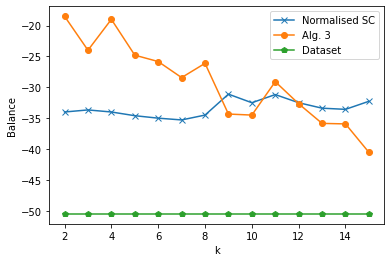

In [523]:
axis_x = np.arange(2, 16, 1)

plt.plot(axis_x, unfair_results, label = 'Normalised SC', marker='x')
plt.plot(axis_x, fair_results, label = 'Alg. 3', marker='o')
plt.plot(axis_x, balance_fairness, label = 'Dataset', marker='p')
print('Spectral Clustering results :', np.mean(unfair_results))
print('Fair Spectral Clustering results :', np.mean(fair_results))
plt.xlabel('k')
# Set the y axis label of the current axis.
plt.ylabel('Balance')
# Set a title of the current axes.
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()